# Neural Ordinary Differential Equations (ODE)

## Motivation

The idea behind this project is to learn how to implement ODE Networks using Pytorch with the goal to analyze the architecture and aim to connect ODE analysis with Deep Learning (if possible connect this with Hybrid Theory).

##### ODENet Advantages
<ul>
<li>Accurate time series predictions</li>
<li>ODENets are faster than recurrent networks</li>
<li>Using ODENets opens new mathematical doors, which might introduce training guarantees and roboustnes (current research topic). </li>
</ul>

### Project Progress

This presentation will walk through the logic behind ODENets. However, in depth examples and the architecture analysis (from an ODE perspective) are still a work in progress. If time allows, a discontinuty analysis will be included to the final Notebook.

## Residual Networks (ResNets)

Researcher's realized in 2015 that increasing a network's depth does not work by simply stacking more layers together. Stacking more layers introduces vanishing or exploding gradient issues and makes the model prone to overfitting; which saturates performance results.

ResNet solves the layer stacking issue by skipping layers using "identity shortcut connection".


A ResNet does not learn the transformation to the next layer, but it learns what/how is the next represenation different ($h_{t+1}$) from the original one ($h_t$). In essence, what do I need to add to get to the next representation.

<center><img src='RNet.jpg'></center>

$$
\begin{align}
h_{t+1} = h_t + f(h_t,\theta_t)
\label{eq:ResNet} \tag{1}
\end{align}
$$ <br>

Where, $f$ represents the network, $h_t$ the hidden state at layer $t$, $\theta_t$ are the weights at layer $t$, and $h_{t+1}$ is the transformation of the hidden state. The difference here is that we are adding the input to the layer to the output of the layer. By sending the input a ResNet prevents important information of beign discarded by $f$. By doing this ResNets can learn their optimal depth, mitigating gradient problems. <br>

<center><img src='ResNet.png'></center>

However, ResNets still employ many layers and incure a higher memory cost to store intermediate values making ResNets frustating to use on personal computers.

## Ordinary Differential Equations (ODEs)

ODEs relate an unknown function $y$ to its gradient (derivative). The solution to such equation is a function that satisfies the relationship, like the example below. However, we still require an initial value to solve for $A$. Say $y(0) = 15$ then we see that for that initial condition $A = 15$.

$$
\begin{align}
\frac{dy(x)}{dx} &= ky(x) \\
y(x) &= Ae^{kx}
\end{align}
$$ <br>

Often, ODEs are impossible to analytically solve and we depend on numerical solution to find an approximate solution. There are plenty of ODE solver algorithms such as the Trapezoidal Method, Runge-Kutta Method, and Adams. Which you might now as ode23t, ode45, and ode113 if you are familiar with MATLAB. However, a simple way to solve an ODE is using Euler's Method (Equation (2)) where $k$ is a time step. 
<center><img src='Euler.jpg'></center>

$$
\begin{align}
y_1 = y_0 + k\frac{dy(0)}{dt}
\label{eq:ResNet} \tag{2}
\end{align}
$$ <br>

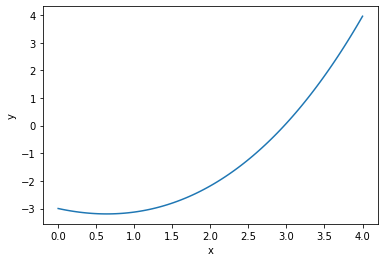

In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function dy/dx = x + y/5.
func = lambda y,x : x + y/5.

# Initial condition
y0 = -3  # at x=0
x = np.linspace(0, 4, 101)

# Solve
y = odeint(func, y0, x)
plt.plot(x, y[:,0])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Connection Between ResNets and ODEs

Notice that both Equations (1) and (2) can be treated as a recursive process. 

<center><img src='Rec.jpg'></center>

Similar, right?
In Euler’s Method we have the ODE relationship $\frac{dy(t)}{dt} = f(y,t)$, stating that the derivative of $y$ is a function of $y$ and $t$. With a starting point for $y$, $y(0)$. 

In a ResNet we also have a starting point, the hidden state at $t = 0$, or the input, $h(0)$. 

So, Instead of an ODE, there are a series of layer transformations, $f(\theta_t)$, where $t$ is the depth of the layer. These transformations are dependent on the specific weights of the layer, $\theta_t$.

Notice the similarity?

What if we take the limit of Equation (1)? We obtain an ODE, meaning that the derivative of the hidden state is parameterized by a Neural Network. Showing that ResNets are a discrete time analogous to an ODE. We can now train a Neural Network such that it will output a correct gradient, meaning that when we solve the ODE at the end point, we will be at the correct label. The Neural Network now parametrized the gradient and can tell us what the gradient at each point in time is, instead of going from input to output. This is a notion for "continuous" layers.

$$
\begin{align}
\frac{dh(t)}{dt} = f(h(t),t,\theta)
\label{eq:ResNet} \tag{3}
\end{align}
$$ <br>


<center><img src='CvsD.jpg'></center>

The main difference between these is that $\theta$ is does not depend on time, the transformation in ODENet is defined for all $t$. Another difference, is that there are fewer parameters in ODENets because of the shared weights, $\theta$. For instance, getting $~0.4$ test error on MNIST a ResNet uses $~600,000$ parameters vs $~200,000$ for an ODENet.

Euler's Method was used to illustrate similarities, but other and better ODE solvers can be used to build ODENets.

## Training ODENets (Adjoint Method)

Now, we have some parameters and we need to train and as mentioned before we are not going from input to output. We now need to specify the entire gradient with respect to the parameters. We need the adjoint sensitivity method or reverse-mode differentiation of and ODE solution to successfully train the network. Note that this is just one way of doing it, it is by no means the only one.


<ol>
<li>Forward Propagate</li>
<li>Solve a second ODE to generate a second curve (to determining how the
gradient of the loss depends on the hidden state)</li>
<li>Solve the second curve </li>
<li>Compute the gradients using a third integral</li>
</ol>

The second curve can be thought as the application of the chain rule. The jumps are the offsets from the loss function.

<center><img src='backprop.png'></center>

<center><img src='adjointeqs.JPG'></center>

<center><img src='adjoint.JPG'></center>

The [adjoint method](https://www.youtube.com/watch?v=jltgNGt8Lpg) scales linearly, this nothing new this method has been used since 1962.


## PyTorch Implementation

## ODE Demo Example

In [ ]:
# To run
python ode_demo.py --viz

<center><img src='Torch Example.JPG'></center>

In [ ]:
# From https://github.com/rtqichen/torchdiffeq/blob/master/examples/latent_ode.py

import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=20)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args = parser.parse_args()

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., args.data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])


class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y**3, true_A)


with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')


def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:args.batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


if args.viz:
    makedirs('png')
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)


def visualize(true_y, pred_y, odefunc, itr):

    if args.viz:

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001)


class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y**3)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


if __name__ == '__main__':

    ii = 0

    func = ODEFunc()
    optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    end = time.time()

    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)

    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % args.test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii)
                ii += 1

        end = time.time()

## MNIST Example

In [15]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
import torchvision

use_cuda = torch.cuda.is_available()

## Euler ODE Initial Value Problem

In [3]:
def ode_solve(z0, t0, t1, f):
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

## Augmented Dynamics

In [4]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

## Adjoint Algorithm

In [5]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

# Torch Stuff, add to nn.Module
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

## CNN Model

In [6]:
def norm(dim):
    return nn.BatchNorm2d(dim)
def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)
def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

## ODE Model

In [7]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

## Define Model

In [8]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

## Get MNIST Dataset

In [9]:
img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

optimizer = torch.optim.Adam(model.parameters())


## Define Training

In [10]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

## Define Test

In [11]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

## Training

In [12]:
n_epochs = 3
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...



Test Accuracy: 10.850%
Training Epoch 1...



Train loss: 0.16216
Testing...



Test Accuracy: 98.580%
Training Epoch 2...



Train loss: 0.04983
Testing...



Test Accuracy: 99.110%
Training Epoch 3...



Train loss: 0.03604
Testing...



Test Accuracy: 98.820%


## Plot Accuracy

<Figure size 648x360 with 0 Axes>

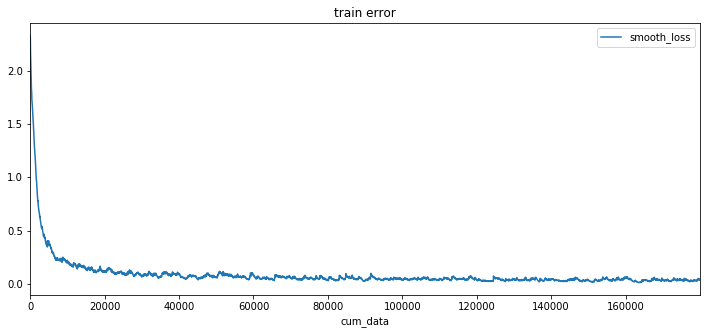

In [16]:
plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

# Torchdyn

For simple/quick implementations using TorchDYN might be the easiest way to explore NeuralODEs.

## Simple ODE Examples using TorchDYN

In [13]:
from torchdyn.models import *; from torchdyn.data_utils import *
from torchdyn import *
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

import torch.nn as nn
import pytorch_lightning as pl

#### Generate Data

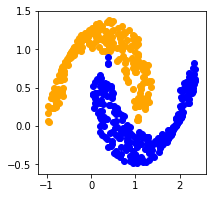

In [14]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, dataset_type='moons', noise=.4)
colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

#### Data Processing

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

#### Learner

In [16]:
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module, settings:dict={}):
        super().__init__()
        defaults.update(settings)
        self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)   
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

#### Vanilla NeuralODE

In [17]:
# model settings (yes, as simple as this)
settings = {'type':'classic', 'controlled':False, 'solver':'dopri5'}

# vector field parametrized by a NN
f = DEFunc(nn.Sequential(
        nn.Linear(2, 64),
        nn.Tanh(), 
        nn.Linear(64, 2)))

# neural ODE (yes, that's it!)
model = NeuralDE(f, settings).to(device)

#### Training

In [18]:
learn = Learner(model)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:GPU available: True, used: False
INFO:lightning:
  | Name             | Type       | Params
--------------------------------------------
0 | model            | NeuralDE   | 322   
1 | model.defunc     | DEFunc     | 322   
2 | model.defunc.m   | Sequential | 322   
3 | model.defunc.m.0 | Linear     | 192   
4 | model.defunc.m.1 | Tanh       | 0     
5 | model.defunc.m.2 | Linear     | 130   
6 | model.adjoint    | Adjoint    | 0     


1

#### Plot Results

In [19]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))

NameError: name 'st' is not defined

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory, yn, len(X),)

In [ ]:
# Trajectories in space-depth
plot_2D_space_depth(s_span, trajectory, yn, len(X))

## Takeaways

1. Optimize backpropagation with a constant memory footprint.

2. Hidden layers as a continuous sequence in contrast with a discrete sequence

3. Adaptive computing: accuracy vs training time tradeoff.

4. Parameter efficiency and constant memory footprint.

5. Scalable and invertible normalizing flows: formula are easier to compute.

6. Connection between Differential Equations and Deep Learning.

7. Using Torchdyn is really simple to implement/use NeuralODEs.

## Future (Summer) Work

Can we represent the ODE as a hybird system?
Can we implement this on systems with discontinuities? <br>
What about PDEs? <br>
Read ICLR ODE papers, there's going to be a Neural Network ODE workshop.

<center><img src='discrete.png'></center>
This figure shows a system with discontinuities.

### References

https://msurtsukov.github.io/Neural-ODE/ <bR>
https://github.com/rtqichen/torchdiffeq <br>
https://github.com/DiffEqML/torchdyn/tree/master/tutorials